In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime as dt
import os
import numpy_indexed as npi
%matplotlib inline

#File paths
os.chdir('/Users/hausfath/Desktop/Climate Science/Carbon Brief/100% Human/')
forcing_file = '/Users/hausfath/Desktop/Climate Science/Carbon Brief/100% Human/Forcing.xlsx'
temp_file = '/Users/hausfath/Desktop/Climate Science/Model GCM Comparison/global_temps_standard.csv'
enso_file = '/Users/hausfath/Desktop/Climate Science/Carbon Brief/Model Obs Comps/ENSO Kaplan.xlsx'
land_file = '/Users/hausfath/Desktop/Climate Science/Carbon Brief/100% Human/berkeley_land.xlsx'

#Options
series = 'Berkeley'
d1 = 4
d2 = 209.5
c1 = 0.404
c2 = 0.351
vd1 = d1
vd2 = d2
vd1 = 1
vd2 = 209.5
vc1 = c1 
vc2 = c2




In [68]:
def import_forcings(forcing_file):
    rf = pd.read_excel(forcing_file, sheetname='Sheet1') 
    rf['year'] = rf['date'].astype(int)
    rf['month'] = ((rf['date'] - rf['year']) * 12 + 1).round(0).astype(int)
    return rf

def remove_enso(series, temp_file, enso_file):
    temps = pd.read_csv(temp_file)
    temps['temp'] = temps[series]
    temps['year'] = temps['date'].astype(int)
    temps['month'] = ((temps['date'] - temps['year']) * 12 + 1).round(0).astype(int)
    enso = pd.read_excel(enso_file, sheetname='Sheet1') 
    enso['year'] = enso['date'].astype(int)
    enso['month'] = ((enso['date'] - enso['year']) * 12 + 1).round(0).astype(int)
    temps = pd.merge(
        temps,
        enso,
        left_on=['year', 'month'],
        right_on=['year', 'month'],
        how='outer'
    )
    for n in range(1,10):
        temps['enso_'+str(n)] = temps['enso'].shift(n)
    temps_subset = temps.dropna(subset=[[series, 'enso_3']])
    smresults = smf.ols('temp ~ enso_3', temps_subset).fit()
    temps['enso_3'].fillna(0, inplace=True)
    temps['pred'] = temps['enso_3'] * smresults.params.enso_3 + smresults.params.Intercept
    temps['temps_enso'] = temps['temp']
    temps['temps_no_enso'] = temps['temps_enso'] - temps['pred']
    temps['temps_no_enso'] = calc_anomaly(temps, 'temps_no_enso')
    temps['temps_enso'] = calc_anomaly(temps, 'temps_enso')
    return temps[['year', 'month', 'temps_enso', 'temps_no_enso']]

def berkeley_land(land_file):
    temps = pd.read_excel(land_file, sheetname='Sheet1') 
    temps['temps_enso'] = temps['anomaly']
    temps['temps_no_enso'] = temps['anomaly']
    temps['temps_no_enso'] = calc_anomaly(temps, 'temps_no_enso')
    temps['temps_enso'] = calc_anomaly(temps, 'temps_enso')
    return temps[['year', 'month', 'temps_enso', 'temps_no_enso', 'uncertainty']]

def calc_anomaly(temps, name):
    start = temps['year'][0] 
    end = temps['year'][50]
    baseline = temps.loc[(temps['year'] >= start) & (temps['year'] <= end), name].mean()
    temps[name] = temps[name] - baseline
    return temps[name]

def temp_response(forc, d1, d2, c1, c2):
    f1 = 1 - np.exp(-1./d1/12.)
    f2 = 1 - np.exp(-1./d2/12.)    
    temp1 = [0]
    temp2 = [0]
    for i in range(1, len(forc.index)):
        temp1.append(temp1[i-1] + (forc.values[i-1] + forc.values[i]) * c1 * f1 / 2. - temp1[i-1] * f1) 
        temp2.append(temp2[i-1] + (forc.values[i-1] + forc.values[i]) * c2 * f2 / 2. - temp2[i-1] * f2) 
    return np.add(temp1, temp2)

def calc_anthro_natural_forcings(rf, temps, d1, d2, c1, c2, vd1, vd2, vc1, vc2):
    forcings = ['total', 'anthro']    
    for forcing in forcings:
        rf[forcing+'_warming'] = temp_response(rf[forcing], d1, d2, c1, c2)
    forcings = ['nat']    
    for forcing in forcings:
        rf[forcing+'_warming'] = temp_response(rf[forcing], vd1, vd2, vc1, vc2)
    data = pd.merge(
    rf,
    temps,
    left_on=['year', 'month'],
    right_on=['year', 'month'],
    how='outer'
    )
    data_subset = data.dropna(subset=[['total', 'temps_enso', 'temps_no_enso']])
    smresults = smf.ols('temps_enso ~ nat_warming + anthro_warming', data_subset).fit()
    intercept_anthro = smresults.params.Intercept
    data['anthro_temp'] = (smresults.params.anthro_warming * data['anthro_warming'])

    smresults = smf.ols('temps_no_enso ~ nat_warming + anthro_warming', data_subset).fit()
    intercept_nat = smresults.params.Intercept

    data['nat_temp'] = (smresults.params.nat_warming * data['nat_warming'])
    data['total_temp'] =  data['nat_temp'] + data['anthro_temp']
    data['temps_enso'] = data['temps_enso'] - intercept_anthro 
    return {
        'results' : data,
        'anthro_coef' : smresults.params.anthro_warming,
        'nat_coef' : smresults.params.nat_warming
    }

def solar_volc_test(rf, temps, d1, d2, c1, c2, vd1, vd2, vc1, vc2):
    forcings = ['total', 'anthro', 'volc', 'solar']    
    for forcing in forcings:
        rf[forcing+'_warming'] = temp_response(rf[forcing], d1, d2, c1, c2)
    forcings = ['nat']    
    for forcing in forcings:
        rf[forcing+'_warming'] = temp_response(rf[forcing], vd1, vd2, vc1, vc2)
    #rf['nat_warming'] = rf['volc_warming'] + rf['solar_warming']
    #print rf.head()
    data = pd.merge(
    rf,
    temps,
    left_on=['year', 'month'],
    right_on=['year', 'month'],
    how='inner'
    )
    smresults = smf.ols('temps_enso ~ volc_warming + solar_warming + anthro_warming', data).fit()
    print(smresults.summary())
    data['anthro_temp'] = (smresults.params.anthro_warming * data['anthro_warming'])
    intercept = smresults.params.Intercept
    
    smresults = smf.ols('temps_no_enso ~ volc_warming + solar_warming + anthro_warming', data).fit()
    print(smresults.summary())
    data['solar_temp'] = (smresults.params.solar_warming * data['solar_warming'])
    data['vulc_temp'] = (smresults.params.volc_warming * data['volc_warming'])
    data['total_temp'] =  data['solar_temp'] + data['vulc_temp'] + data['anthro_temp']
    data[['temps_enso', 'total_temp', 'solar_temp', 'vulc_temp', 'anthro_temp']].plot()
    return {
        'results' : data,
        'anthro_coef' : smresults.params.anthro_warming,
        'volc_coef' : smresults.params.volc_warming,
        'solar_coef' : smresults.params.solar_warming
    }

def calc_other_forcings(data, anthro_coef, nat_coef, d1, d2, c1, c2, vd1, vd2, vc1, vc2, save_name):
    forcings = ['total', 'anthro', 'co2', 'wmghg', 'o3Tr', 'o3St', 'luc', 'aero']    
    for forcing in forcings:
        data[forcing+'_warming'] = temp_response(data[forcing], d1, d2, c1, c2)
    forcings = ['volc', 'solar', 'nat']    
    for forcing in forcings:
        data[forcing+'_warming'] = temp_response(data[forcing], vd1, vd2, vc1, vc2)
    nat_forcings = ['volc', 'solar'] 
    for forcing in nat_forcings:
        data[forcing+'_temp'] = nat_coef * data[forcing+'_warming']
    anthro_forcings = ['co2', 'wmghg', 'o3Tr', 'o3St', 'luc', 'aero'] 
    for forcing in anthro_forcings:
        data[forcing+'_temp'] = anthro_coef * data[forcing+'_warming']
    data['ghg_temp'] = data['co2_temp'] + data['wmghg_temp']
    if save_name == 'global':
        data.to_csv('forcing_analysis.csv')
    if save_name == 'land':
        data.to_csv('forcing_analysis_land.csv')
    return data

def forcing_run(series, forcing_file, temp_file, enso_file, d1, d2, c1, c2, vd1, vd2, vc1, vc2):
    temps = remove_enso(series, temp_file, enso_file)
    results = pd.DataFrame()
    for n in range(200):
        n_s = str(n + 1).zfill(3)
        print n_s
        rf = pd.read_csv('/Users/hausfath/Desktop/Climate Science/Carbon Brief/100% Human/forcings/GWI_piers_forcing_mem'+n_s+'.csv', sep=' ') 
        rf.columns.values.tolist()
        rf.columns = ['date', 'anthro', 'nat', 'total']
        rf['date'] = (rf['date'] - 0.042).round(2)
        rf['year'] = rf['date'].astype(int)
        rf['month'] = ((rf['date'] - rf['year']) * 12 + 1).round(0).astype(int)
        df = calc_anthro_natural_forcings(rf, temps, d1, d2, c1, c2, vd1, vd2, vc1, vc2)['results'][['month', 'year', 'anthro_temp', 'nat_temp', 'total_temp']]
        df.columns = ['month', 'year', 'anthro_temp_'+str(n+1), 'nat_temp_'+str(n+1), 'total_temp_'+str(n+1)]
        try:
            results = pd.merge(results, df, how='outer', right_on=['month', 'year'], left_on=['month', 'year'])
        except:
            print 'FAIL'
            results = df
    results.to_csv('forcing_analysis_uncertainty.csv')


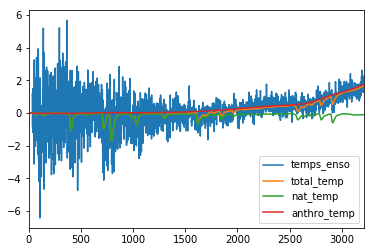

In [69]:
#test = solar_volc_test(rf, temps, d1, d2, c1, c2, vd1, vd2, vc1, vc2)
#save_name = 'global'
temps = berkeley_land(land_file)
#temps = remove_enso(series, temp_file, enso_file)
rf = import_forcings(forcing_file)
df = calc_anthro_natural_forcings(rf, temps, d1, d2, c1, c2, vd1, vd2, vc1, vc2)
vals = calc_other_forcings(df['results'], df['anthro_coef'], df['nat_coef'], d1, d2, c1, c2, vd1, vd2, vc1, vc2, save_name)
vals[['temps_enso', 'total_temp', 'nat_temp', 'anthro_temp']].plot()


#forcing_run(series, forcing_file, temp_file, enso_file, d1, d2, c1, c2, vd1, vd2, vc1, vc2)
